In [1]:
# Manipulação dos Dados
import numpy as np
import pandas as pd
import os

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

https://www.hfbrasil.org.br/br/banco-de-dados-precos-medios-dos-hortifruticolas.aspx

#### Frutas
- Banana
- Maçã
- Manga
- Melancia
- Uva
       

### Carregando os Dados

In [2]:
path = os.getcwd()
files = os.listdir(path)
files_xls = [f for f in files if f[-4:] == 'xlsx']

In [3]:
nomes_frutas = ['banana', 'maca', 'manga', 'melancia', 'uva']
for file, fruta in zip(files_xls, nomes_frutas):
    exec(f'df_{fruta} = pd.read_excel("{file}")')

#### Função que realiza limpeza do DataFrame

In [5]:
def alteracao(dataframe, fruta, variacao_fruta, ano, unidade = False):
    
    df = dataframe.copy()
    
    # Retirando a última linha que contém a fonte dos dados
    df = df.iloc[:-1, ]
    
    # Apenas 2022
    df = df[df['Ano'] == ano]
    
    # Retirando colunas Região e Moeda
    df = df.drop(columns = ['Região', 'Moeda'], axis = 1)
    
    # Mantendo apenas um tipo de banana - Prata anã
    df = df[df['Produto'] == variacao_fruta]
    
    # Manter apenas a primeira palavra que denomina a variação da fruta
    df['Produto'] = df['Produto'].apply(lambda x: x.split()[0])
    
    # Inserindo nome da fruta na frente da variação
    if(fruta == df['Produto'].unique()[0]):
        pass
    else:
        df['Produto'] = df['Produto'].apply(lambda x: fruta + ' ' + x)
    
    # Mantendo a unidade em formato numérico e transformando para float
    if (unidade == True) and (df['Unidade'].unique()[0] == 'quilograma'):
        pass
    elif unidade:
        df['Unidade'] = df['Unidade'].str.extract('(\d+)').astype(int)
    else:
        pass
    
    # Obtendo Preco por Quilo
    if df['Unidade'].dtype == int:
        df['Preco/KG'] = round(df['Preço'] / df['Unidade'], 2)
    elif df['Unidade'].unique()[0] == 'quilograma':
        df['Preco/KG'] = df['Preço']
    else:
        raise TypeError('Você esqueceu de passar o parâmetro unidade como True!\
 Passe para que o preço por quilo apareça!')
    

    # Criando coluna de data (mês/ano)
    df['Mês'] = df['Mês'].astype(int).astype(str)
    df['Ano'] = df['Ano'].astype(int).astype(str)
    df['Data'] = df['Ano'] + '-' + df['Mês']
    df['Data'] = pd.to_datetime(df['Data'], format = '%Y-%m').dt.strftime('%Y-%m')
    df = df.sort_values(by = 'Data', ascending = True)
    
    # Deletando colunas que não serão utilizada
    df = df.drop(columns = ['Mês', 'Ano', 'Unidade','Preço'], axis = 1)
    

    return df

In [6]:
df_banana_22 = alteracao(df_banana, 'Banana', 'Prata anã primeira - atacado', 2022, unidade = True)
df_maca_22 = alteracao(df_maca, 'Maca', 'Gala graúda Cat 1 - atacado', 2022, unidade = True)
df_manga_22 = alteracao(df_manga, 'Manga', 'Tommy - atacado', 2022)
df_melancia_22 = alteracao(df_melancia, 'Melancia', 'Melancia Redonda/Comprida - Graúda (>12 KG) - atacado', 2022)
df_uva_22 = alteracao(df_uva, 'Uva', 'Itália - atacado', 2022)

In [7]:
df = pd.concat([df_banana_22, df_maca_22, df_manga_22, df_melancia_22, df_uva_22], axis = 0).reset_index()
df = df.drop(columns = ['index'], axis = 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Produto   60 non-null     object 
 1   Preco/KG  60 non-null     float64
 2   Data      60 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


### Evolução dos Preços em 2022

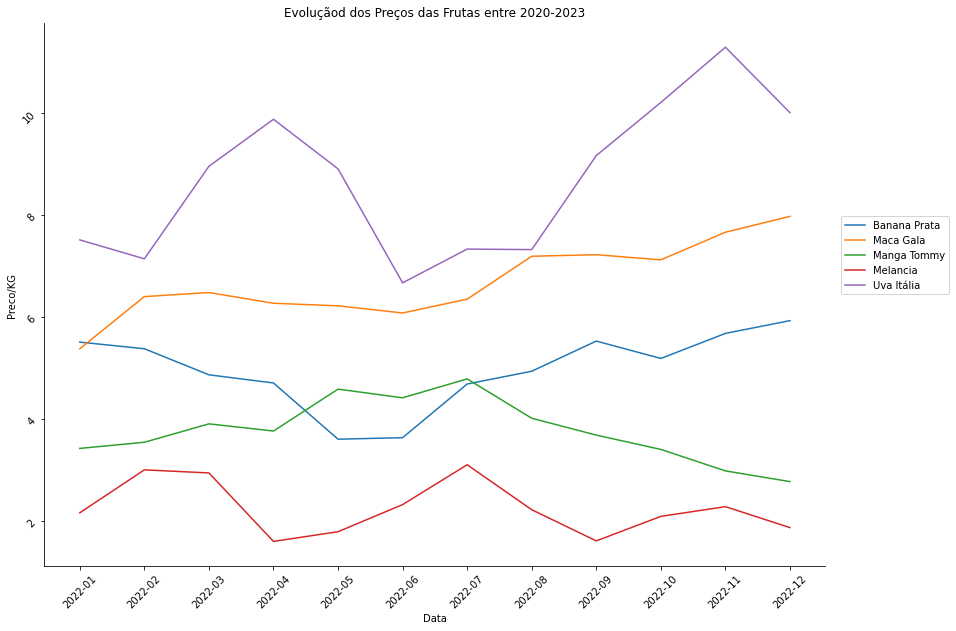

In [9]:
fig, ax = plt.subplots(figsize = (14, 10))

sns.lineplot(x = df['Data'], y = df['Preco/KG'], hue = df['Produto'])

# Formatacao do Grafico
ax.set_title('Evoluçãod dos Preços das Frutas entre 2020-2023')
ax.tick_params(labelrotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = (1.02, 0.5))
plt.show();

### Corrigindo pela inflação

In [10]:
from bcb import sgs

In [11]:
class AcumulandoInflacaoDiaria:

    def __init__(self, indice, numero_serie, inicio, fim):
        self.indice = indice
        self.numero_serie = numero_serie
        self.inicio = inicio
        self.fim = fim
        
        self.importando_dados_api()
        
    def importando_dados_api(self):
        
        # Obtendo dados da API
        self.df_inflacao = sgs.get({self.indice : self.numero_serie}, start = self.inicio, end = self.fim)

        # Retirando a coluna do indice para realizar alteracoes
        self.df_inflacao = self.df_inflacao.reset_index()

        # Renomeando colunas
        self.df_inflacao.columns = ['Data', self.indice]

In [12]:
Inflacao_Mensal = AcumulandoInflacaoDiaria(indice = 'ipca', numero_serie = 433, inicio = '2022-01-01', fim = '2023-02-02')
Inflacao_Mensal = Inflacao_Mensal.df_inflacao

In [13]:
def corrigindo_inflacao(df_nao_corrigido, df_inflacao):
    
    # Alterando df_treino
    df_inflacao_copia = df_inflacao.copy()
    df_inflacao_copia['Data'] = df_inflacao_copia['Data'].dt.strftime('%Y-%m')
    
    # Deflacionando para preços de 2020
    df_inflacao_copia['indice_2022'] = 1 * (1 + (df_inflacao_copia['ipca'] / 100))
    df_inflacao_copia.head(1).iloc[0,-1] = 1
    df_inflacao_copia['inflacao_acumulada'] = df_inflacao_copia['indice_2022'].cumprod()
    
    # Unindo os dois dataframes
    df_pronto = pd.merge(df_nao_corrigido, df_inflacao_copia, left_on = 'Data', right_on = 'Data', how = 'inner')
    
    # Colocando a data no indice
    #df_pronto.set_index('Data', inplace = True)
    
    
    # Corrigido pela inflação
    df_pronto['Preco_Corrigido'] = round(df_pronto['Preco/KG'] / df_pronto['inflacao_acumulada'], 2)
    
    # Mantendo colunas relevantes
    df_pronto = df_pronto[['Data', 'Produto', 'Preco/KG', 'Preco_Corrigido']]
    
    return df_pronto

In [14]:
df_corrigido_inflacao = corrigindo_inflacao(df, Inflacao_Mensal)

### Preço Nominal x Preço Real

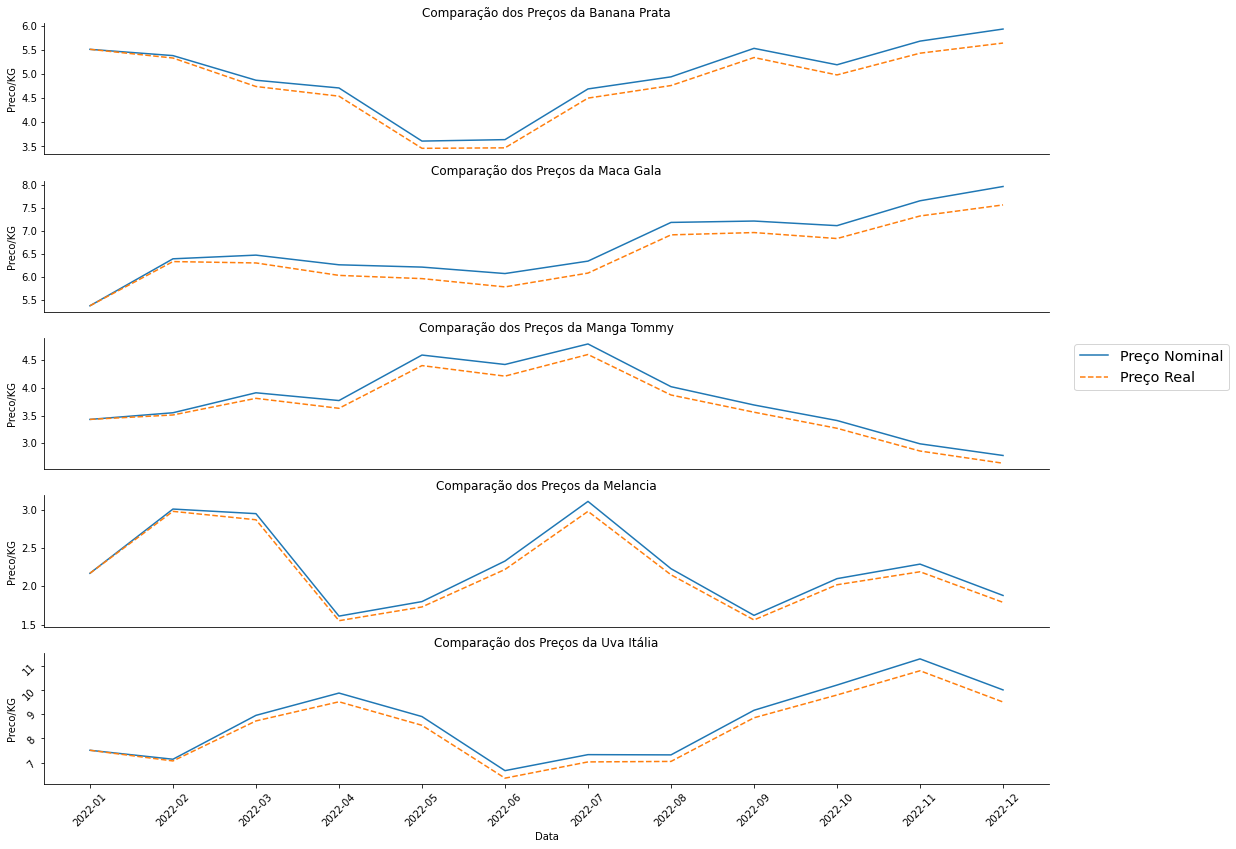

In [15]:
fig, ([ax1, ax2, ax3, ax4, ax5]) = plt.subplots(5, 1, figsize = (18, 14))

axes = [ax1, ax2, ax3, ax4, ax5]

for produto, ax in zip(df_corrigido_inflacao['Produto'].unique(), axes):
    df_plot = df_corrigido_inflacao[df_corrigido_inflacao['Produto'] == produto]
    sns.lineplot(x = df_plot['Data'],
                 y = df_plot['Preco/KG'], ax = ax)
    
    sns.lineplot(x = df_plot['Data'],
                 y = df_plot['Preco_Corrigido'], ax = ax, linestyle = '--')

    # Formtação do Gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'Comparação dos Preços da {produto}')
    
  
    if ax == ax5:
        ax.tick_params(labelrotation=45)
        ax.legend(['Preço Nominal', 'Preço Real'], loc = (1.025, 3), fontsize = 'x-large')
    else:
        ax.set_xticks([])
        ax.set(xlabel = None)

### Preço Médio

A Uva teve o maior preço médio do quilo registrado entre as cinco frutas, ficando em R$8,39. Em seguida aparece a Maçã, com R$6,46 reais/kg. A Melancia foi a fruta com o menor preço médio registrado no ano, cerca de R$2,18. 

In [16]:
anos = ['2022']

for ano in anos:
    print(f'Resultado para o ano de {ano}')
    print('-' * 40)
    df_filtrado = df_corrigido_inflacao[df_corrigido_inflacao['Data'].str.contains(ano)]
    media = round(df_filtrado.groupby(['Produto'], as_index = False)['Preco_Corrigido'].mean(), 2)
    media['Preco_Corrigido'] = media['Preco_Corrigido'].apply(lambda x: "R${:.2f}".format(x))
    print(media)

Resultado para o ano de 2022
----------------------------------------
        Produto Preco_Corrigido
0  Banana Prata          R$4.81
1     Maca Gala          R$6.46
2   Manga Tommy          R$3.65
3      Melancia          R$2.18
4    Uva Itália          R$8.39


#### Variação em 2022

Aqui avaliamos a variação ocorrida nos preços dessas frutas entre janeiro de 2022 e dezembro de 2022. Consideramos os preços corrigidos pela inflação para avaliar a variação real dos preços.

A manga e a melancia foram as duas frutas, entre as cinco selecionadas, que apresentaram queda no seu preço real em 2022. A primeira registrou uma queda de cerca de 23% e a segunda uma queda de 17,51%. Elas ficaram mais baratas mesmo considerando o preço sem correção pela inflação.

A banana prata apresentou uma leve alta no preço, registrando 2,36% de aumento real no ano. Podemos perceber que o componente principal de aumento no preço nominal da fruta foi a inflação.

Por fim, as frutas que registraram maior alta nos preços foram a Maçã e a Uva, respectivamente 40,71% e 26,50%. A variação de preços foi bem acima da inflação registrada no ano, o que nos leva a concluir que esse aumento está mais relacionado ao próprio mercado de cada fruta.

In [17]:
df_filtrado = df_corrigido_inflacao[(df_corrigido_inflacao['Data'] == '2022-01')\
                                    | (df_corrigido_inflacao['Data'] == '2022-12')]

for produto in df_filtrado['Produto'].unique():
    preco_inicial = df_filtrado[df_filtrado['Produto'] == produto].iloc[0, -1]
    preco_final = df_filtrado[df_filtrado['Produto'] == produto].iloc[1, -1]
    variacao = (preco_final - preco_inicial)
    print(f'Análise da fruta: {produto}!')
    print(f'O preço inicial é de: {preco_inicial:.2f}! O preço final é de: {preco_final:.2f}!')
    print(f'A variação absoluta de preços é de R${variacao:.2f}!')
    print(f'O que corresponde a uma variação percentual de {(variacao / preco_inicial):.2%}')
    print('-' * 40)

Análise da fruta: Banana Prata!
O preço inicial é de: 5.51! O preço final é de: 5.64!
A variação absoluta de preços é de R$0.13!
O que corresponde a uma variação percentual de 2.36%
----------------------------------------
Análise da fruta: Maca Gala!
O preço inicial é de: 5.38! O preço final é de: 7.57!
A variação absoluta de preços é de R$2.19!
O que corresponde a uma variação percentual de 40.71%
----------------------------------------
Análise da fruta: Manga Tommy!
O preço inicial é de: 3.43! O preço final é de: 2.64!
A variação absoluta de preços é de R$-0.79!
O que corresponde a uma variação percentual de -23.03%
----------------------------------------
Análise da fruta: Melancia!
O preço inicial é de: 2.17! O preço final é de: 1.79!
A variação absoluta de preços é de R$-0.38!
O que corresponde a uma variação percentual de -17.51%
----------------------------------------
Análise da fruta: Uva Itália!
O preço inicial é de: 7.51! O preço final é de: 9.50!
A variação absoluta de pr

### Variação nos Preços

Agora olhamos para a oscilação de preços que cada fruta sofreu durante o ano. A Uva foi a fruta que teve maior oscilação em seus preços, apresentando um desvio-padrão médio de 0,60. As frutas restantes não tiveram diferenças acentuadas em relação as outras, ficando entre 0,22 - a menor oscilação registrada para a fruta Melancia - e 0,32, da Banana prata.

In [18]:
def estatisticas_descritivas(dataframe, coluna):
    
    df = dataframe.copy()
    
    # Normalizando as variáveis (Estão em escalas diferentes)
    media = np.mean(df[coluna])
    desvio_padrao = np.std(df[coluna])
    df[coluna] = (df[coluna] - media) / desvio_padrao

    # Calculando Média, Variancia e Desvio-Padrao
    df_resultados = df.groupby(['Produto'], as_index = False)[['Preco_Corrigido']].agg(['mean', 'var', 'std'])
    
    # Arredondadno para duas casas decimais
    df_resultados = df_resultados.apply(lambda x: round(x, 2))
    
    return df_resultados

In [19]:
estatisticas_descritivas(df_corrigido_inflacao, 'Preco_Corrigido')

Preco_Corrigido            
                        mean   var   std
Produto                                 
Banana Prata           -0.13  0.10  0.32
Maca Gala               0.59  0.08  0.29
Manga Tommy            -0.63  0.06  0.25
Melancia               -1.26  0.05  0.22
Uva Itália              1.43  0.36  0.60

### O que está por vir em 2023...

In [20]:
# Dados de 2023
df_banana_23 = alteracao(df_banana, 'Banana', 'Prata anã primeira - atacado', 2023, unidade = True)
df_maca_23 = alteracao(df_maca, 'Maca', 'Gala graúda Cat 1 - atacado', 2023, unidade = True)
df_manga_23 = alteracao(df_manga, 'Manga', 'Tommy - atacado', 2023)
df_melancia_23 = alteracao(df_melancia, 'Melancia', 'Melancia Redonda/Comprida - Graúda (>12 KG) - atacado', 2023)
df_uva_23 = alteracao(df_uva, 'Uva', 'Itália - atacado', 2023)

In [21]:
# Pegando dados de janeiro de 2023
df_23 = pd.concat([df_banana_23, df_maca_23, df_manga_23, df_melancia_23, df_uva_23], axis = 0).reset_index()
df_23 = df_23.drop(columns = ['index'], axis = 1)

# Filtrando para dados de dezembro de 2022
df_22_dez = df[(df['Data'] == '2022-12') | (df['Data'] == '2022-01')]

# Contatenando as informações de dez-22 e jan-23
df_novo_ano = pd.concat([df_22_dez, df_23], axis = 0).reset_index()
df_novo_ano = df_novo_ano.drop(columns = ['index'], axis = 1)

### Comparação Dez-2022 e Jan-2023

O ano de 2023 começa com expectativas de menor inflação durante o ano, apesar das incertezas econômicas. Informações sobre eventos que afetam o preço de cada fruta em específico ocorrem durante o ano e muitas são impossíveis de prever. Porém, os preços médios para a capital de São Paulo já estão disponíveis e oferecem o ponto de começo para o novo ano. A melhor notícia vem da Uva. O seu preço médio em janeiro foi de R\\$8,39, cerca de 16\% mais barata em relação ao mês de dezembro de 2022. Dentre as cinco frutas, foi a única que registrou queda.

A fruta que apresentou maior alta de preços entre dezembro e janeiro foi a Melancia. Passando de R\\$1,88 para R\\$2,55, o aumento foi de 35,64\%. Bem acima da prévia da inflação para janeiro que foi de 0,55\%. A Maçã foi a segunda fruta com maior alta, mas bem modesta se comparado com o registrado nos preços da Melancia. A alta da Maçã do tipo Gala foi de 2,88\%.

Por fim, a Banana e a Manga apresentaram uma pequena alta nos preços, com menos de 2\% de oscilação para ambos os casos.

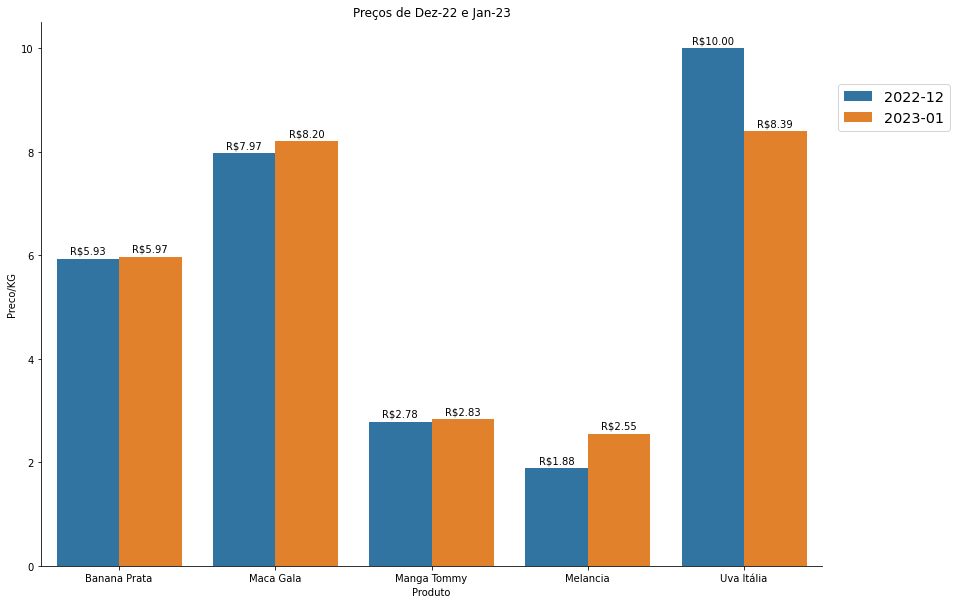

In [22]:
fig, ax = plt.subplots(figsize = (14, 10))


sns.barplot(x = df_novo_ano[df_novo_ano['Data'] != '2022-01']['Produto'],
            y = df_novo_ano[df_novo_ano['Data'] != '2022-01']['Preco/KG'],
            hue = df_novo_ano[df_novo_ano['Data'] != '2022-01']['Data'])

# Formtação do Gráfico
ax.legend(loc = (1.02, 0.8), fontsize = 'x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Preços de Dez-22 e Jan-23')

for container in ax.containers:
    labels = [f'R${x:.2f}' for x in container.datavalues]
    ax.bar_label(container, labels = labels, padding = 3)

plt.show();

### Comparação Jan-2022 e Jan-2023

Quando comparamos o mês de janeiro de 2023 com o mês de janeiro de 2022 o cenário é diferente. Os preços, em geral, são mais altos. Exceto para a Manga, todas as outras frutas registram um preço maior agora em relação ao mês de janeiro do ano passado. A Maçã é a fruta com maior aumento nos preços, com 52,41%, mantendo a tendência de alta registrada durante o ano passado. A Uva, outra fruta que registrou forte aumento de preços em 2022, parece reverter um cenário de alta nos preços. Ainda assim, o preço em janeiro de 2023 é cerca de 11,71% maior em relação ao mesmo período do ano passado.

O destaque positivo é o da Manga. A fruta, que registrou a maior queda nos preços em 2022 entre as analisadas, está mais barata nesse mês de janeiro em relação ao mesmo mês em 2022 - a diferença é de 17,49%. Entretanto, a queda nos preços da Manga parece ter perdido força.

Essas diferenças nos preços de janeiro de 2023 e janeiro de 2022 também refletem o comportamento nos preços durante o ano passado. Para alguns casos, como o da Uva, parece que a alta nos preços perdeu força. Para outros, como a Maçã, o preço médio em janeiro indica que um movimento de alta ainda é registrado.

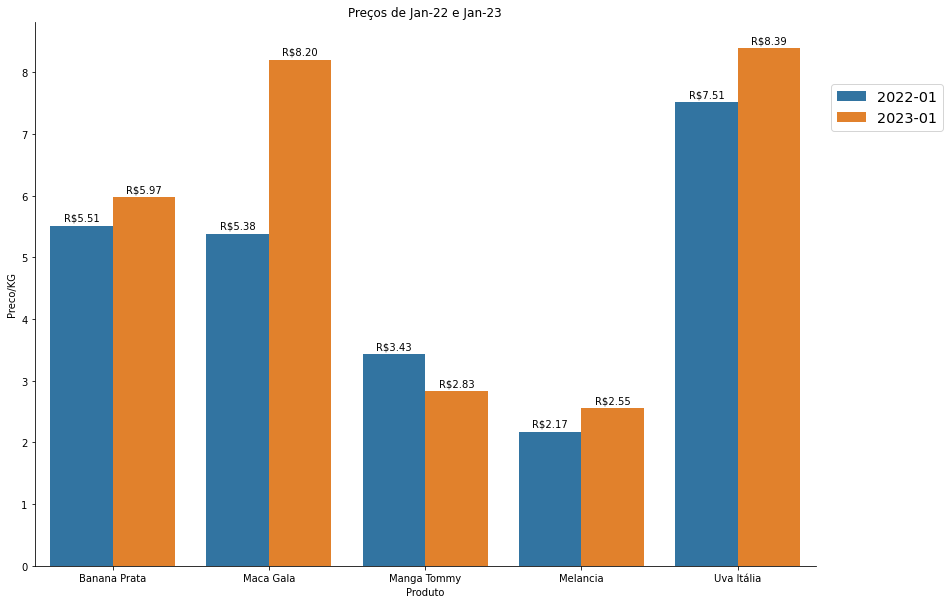

In [23]:
fig, ax = plt.subplots(figsize = (14, 10))


sns.barplot(x = df_novo_ano[df_novo_ano['Data'] != '2022-12']['Produto'],
            y = df_novo_ano[df_novo_ano['Data'] != '2022-12']['Preco/KG'],
            hue = df_novo_ano[df_novo_ano['Data'] != '2022-12']['Data'])

# Formtação do Gráfico
ax.legend(loc = (1.02, 0.8), fontsize = 'x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Preços de Jan-22 e Jan-23')

for container in ax.containers:
    labels = [f'R${x:.2f}' for x in container.datavalues]
    ax.bar_label(container, labels = labels, padding = 3)

plt.show();

# Fim